# WARNING:
- In this notebook, we want to implement loss function (BCE) in order to understand and then implement WGAN-GP.
- But we can't!!
- This notebook is wrong because, our BCE loss is different from nn.BCE PyTorch loss

# Libraries

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
import torchvision
torch.manual_seed(0) # Set for testing purposes, please do not change!

# Google Colab / Your Device
**Because directory system in your device(laptop) is different from google drive, so first determine this section first**

In [37]:
# roots
root_ds='/content/drive/MyDrive/gan-lab/Dataset'
root_models = "/content/drive/MyDrive/gan-lab/Models"

# devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**NOTE:**
Unlike Basic GANs that you played with Nodes, in DCGANs you will play with Channels

# Information

1. We have NO any pooling layer
2. We have 2D batchnorm layer in both G and D.
3. We have NO fully connected hidden layer (nn.Linear).
4. ReLU in hidden layers - Tanh in final layer (Generators)
5. LeakyReLU in hidden layers - NO activation in final layer (Discriminator)
6. You will build a generator using 4 layers (3 hidden layers + 1 output layer)
7. You will use 3 layers in your discriminator's neural network

# Generator

In [38]:
class Generator(nn.Module):
    def __init__(self, C_noise, C_hidden, C_image):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(
            self.gen_block(C_noise   , C_hidden*4, K=3, S=2),
            self.gen_block(C_hidden*4, C_hidden*2, K=4, S=1),
            self.gen_block(C_hidden*2, C_hidden*1, K=3, S=2),
            self.gen_block(C_hidden*1  , C_image , K=4, S=2, final_layer=True)
        )

    def gen_block(self, C_in, C_out, K, S, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(C_in, C_out, kernel_size = K, stride = S),
                nn.Tanh()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(C_in, C_out, kernel_size = K, stride = S),
                nn.BatchNorm2d(C_out),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.gen(x)

# Discriminator

In [39]:
class Discriminator(nn.Module):
    def __init__(self, C_image, C_hidden):
        super(Discriminator, self).__init__()

        self.dis = nn.Sequential(
            self.dis_block(C_image   , C_hidden*1, K=4, S=2),
            self.dis_block(C_hidden*1, C_hidden*2, K=4, S=2),
            self.dis_block(C_hidden*2, 1         , K=4, S=2, final_layer=True),
        )

    def dis_block(self, C_in, C_out, K, S, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(C_in, C_out, kernel_size = K, stride = S)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(C_in, C_out, kernel_size = K, stride = S),
                nn.BatchNorm2d(C_out),
                nn.LeakyReLU(inplace=True, negative_slope=0.2)
            )

    def forward(self, x):
        return self.dis(x).view(x.shape[0], -1)

# Noise

In [40]:
def get_noise(N_noise, C_noise, device='cpu'):
    return torch.randn(N_noise, C_noise, device=device).view(-1, C_noise, 1, 1)

# Losses (NEW)

In [54]:
def BCEWithLogitsLoss(output, target):
    """
    arguments:
        y : desired label
        a_hat : output of ANN before feed to avtivation function
    """
    y_hat = F.sigmoid(output)
    y = target
    target_1 = y*torch.log10(y_hat)
    target_0 = (1-y)*torch.log10(1-y_hat)
    return torch.mean(-target_1 - target_0)

In [62]:
# test
target = torch.tensor(1.0)
output = torch.tensor(100.0)
criterion = torch.nn.BCEWithLogitsLoss()
print(criterion(output, target))
print(BCEWithLogitsLoss(output, target))

tensor(0.)
tensor(nan)


##### why my BCEWithLogitsLoss differ from nn.BCEWithLogitsLoss ???
PyTorch Answer:
https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

# WARNING :
- These Functions are wrong!!!
- Please use nn.BCEWithLogitsLoss PyTorch.

In [41]:
def get_loss_dis(gen, dis,
                 real_image,
                 N_noise, C_noise,
                 device):

    x = real_image
    x_hat = gen( get_noise(N_noise, C_noise, device=device) ).detach()

    return torch.mean(-torch.log10(F.sigmoid(dis(x))), dim=0) + torch.mean(-torch.log10(1 - F.sigmoid(dis(x_hat))), dim=0 )

In [42]:
def get_loss_gen(gen, dis,
                 N_noise, C_noise,
                 device):

    x_hat = gen( get_noise(N_noise, C_noise, device=device) )

    return torch.mean(torch.log10(1 - F.sigmoid(dis(x_hat))), dim=0 )

# Helper Functions

In [43]:
def save_model(gen, dis, epoch, root, mode = None):
    # directory system in colab and pc is different.
    if mode == 'colab':
        filename = root + f'/model_epoch_{epoch}.pt'
    else:
        filename = root + f'\model_epoch_{epoch}.pt'

    torch.save({'epoch' : epoch,
              'model_dis_state_dict' : dis.state_dict(),
              'model_gen_state_dict' : gen.state_dict()},
              filename)

In [44]:
# when you want to continue training GAN from last epoch.
def load_model(gen, dis, root):
    # root = last generator and discriminator parameters that has been saved.
    # gen  = un-initialized generator
    # dis  = un-initialized discriminator

    models=torch.load(root)
    gen.load_state_dict(models['model_gen_state_dict'])
    dis.load_state_dict(models['model_dis_state_dict'])
    return models['epoch']

In [45]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [46]:
def weights_init(submodules):
    if isinstance(submodules, nn.Conv2d) or isinstance(submodules, nn.ConvTranspose2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
    if isinstance(submodules, nn.BatchNorm2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
        torch.nn.init.constant_(submodules.bias, 0)

# Hyperparameters

**WARNING**
batch_size and N_noise in some iteration it is not same!

In [47]:
# Sample numbers of noise and image
N_noise = 128
batch_size =128

# Channels of noise and image
C_noise = 64
C_image = 1

# Channels of hidden layers
C_hidden_gen = 64
C_hidden_dis = 16

# lr/epoch/disp
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

# epochs
epochs= 50
disp_freq=100

# Real Image

In [48]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(root_ds, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

# Create Models / Criterion / Optimizers

In [49]:
# get instance from models
gen = Generator(C_noise, C_hidden_gen, C_image).to(device)
dis = Discriminator(C_image, C_hidden_dis).to(device)

# Initialize
gen = gen.apply(weights_init)
dis = dis.apply(weights_init)

# Optimizers
optim_dis = torch.optim.Adam(dis.parameters(), lr=lr, betas=(beta_1, beta_2))
optim_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

In [50]:
for x,_ in dataloader:
    x=x
    break
x=x.to(device)

In [51]:
get_loss_gen(gen,dis, N_noise, C_noise, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([-0.3000], device='cuda:0', grad_fn=<MeanBackward1>)

# Train

############################################################
###### Epoch 1 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.28	Loss Gen: -0.13


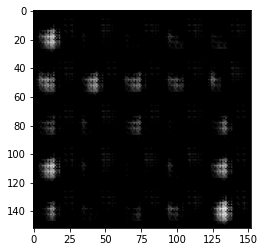

############################################################
###### Epoch 2 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.41	Loss Gen: -0.16


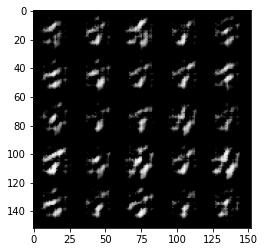

############################################################
###### Epoch 3 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.44	Loss Gen: -0.12


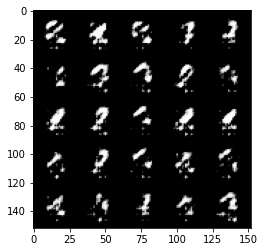

############################################################
###### Epoch 4 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.54	Loss Gen: -0.28


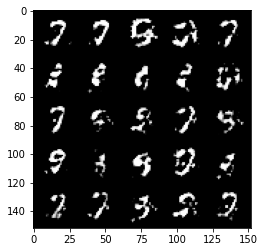

############################################################
###### Epoch 5 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.53	Loss Gen: -0.22


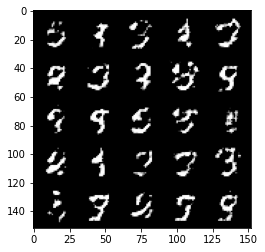

############################################################
###### Epoch 6 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.59	Loss Gen: -0.29


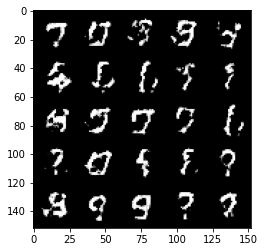

############################################################
###### Epoch 7 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.57	Loss Gen: -0.26


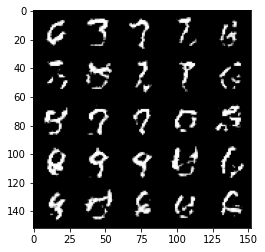

############################################################
###### Epoch 8 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.26


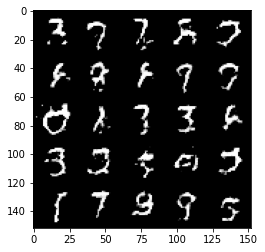

############################################################
###### Epoch 9 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.59	Loss Gen: -0.32


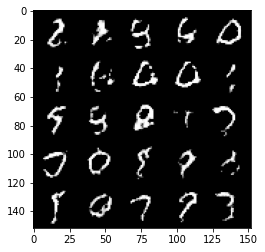

############################################################
###### Epoch 10 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.59	Loss Gen: -0.28


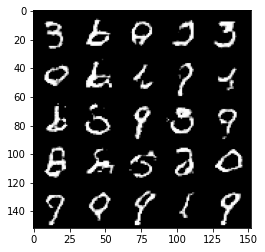

############################################################
###### Epoch 11 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.59	Loss Gen: -0.28


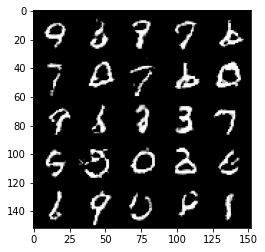

############################################################
###### Epoch 12 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.31


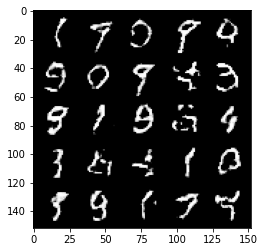

############################################################
###### Epoch 13 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.29


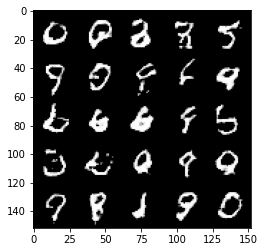

############################################################
###### Epoch 14 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.59	Loss Gen: -0.28


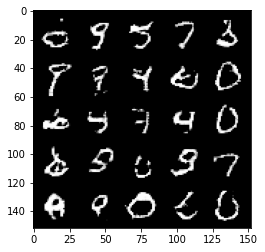

############################################################
###### Epoch 15 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.59	Loss Gen: -0.30


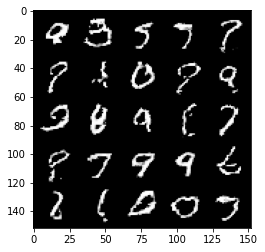

############################################################
###### Epoch 16 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.29


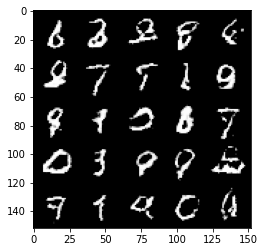

############################################################
###### Epoch 17 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.32


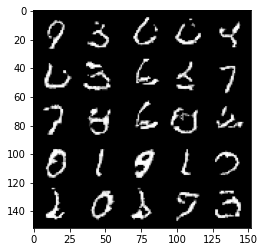

############################################################
###### Epoch 18 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.28


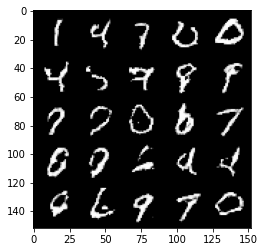

############################################################
###### Epoch 19 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.29


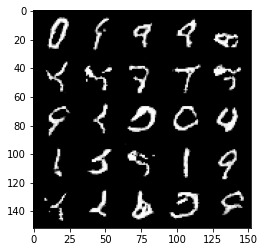

############################################################
###### Epoch 20 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.28


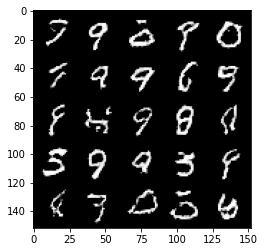

############################################################
###### Epoch 21 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.27


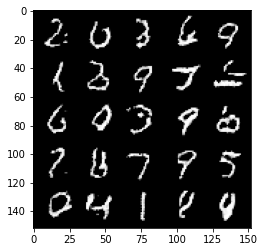

############################################################
###### Epoch 22 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


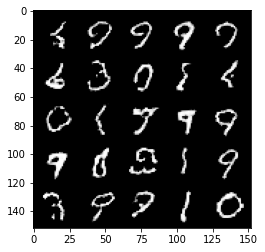

############################################################
###### Epoch 23 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.29


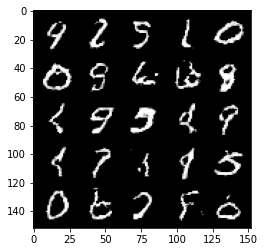

############################################################
###### Epoch 24 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.31


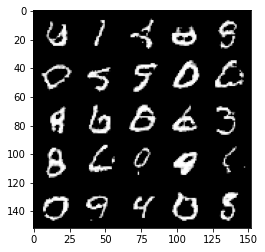

############################################################
###### Epoch 25 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.30


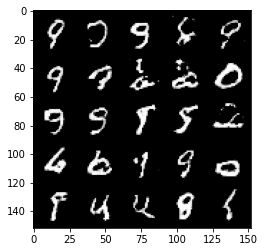

############################################################
###### Epoch 26 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.25


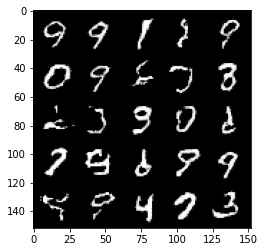

############################################################
###### Epoch 27 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.31


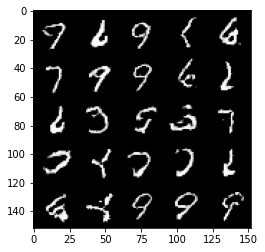

############################################################
###### Epoch 28 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.32


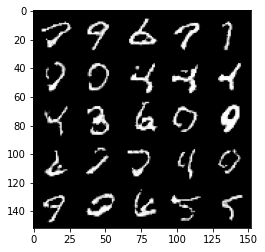

############################################################
###### Epoch 29 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.29


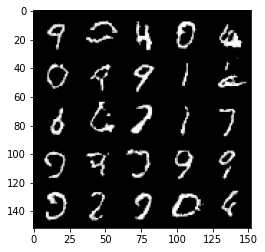

############################################################
###### Epoch 30 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


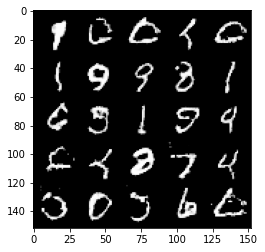

############################################################
###### Epoch 31 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.29


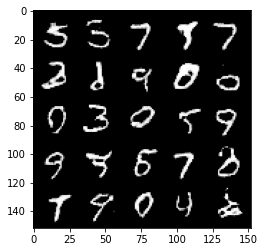

############################################################
###### Epoch 32 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.33


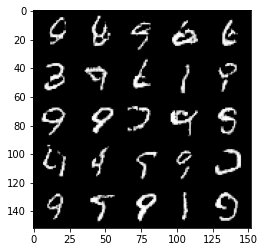

############################################################
###### Epoch 33 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.32


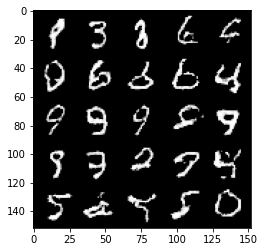

############################################################
###### Epoch 34 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.29


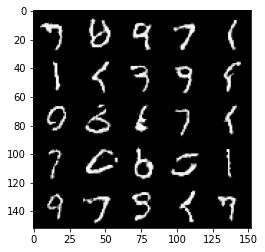

############################################################
###### Epoch 35 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


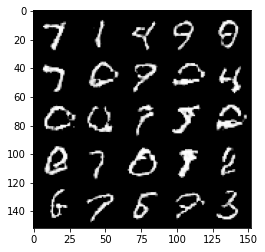

############################################################
###### Epoch 36 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.29


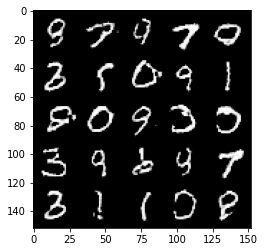

############################################################
###### Epoch 37 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.31


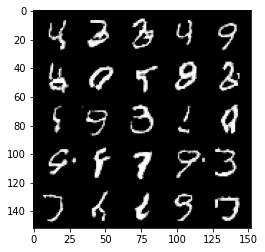

############################################################
###### Epoch 38 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


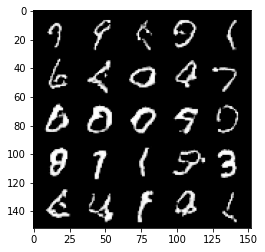

############################################################
###### Epoch 39 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.29


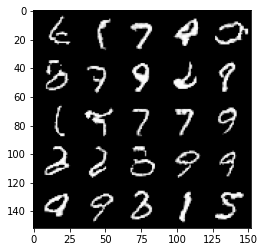

############################################################
###### Epoch 40 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.32


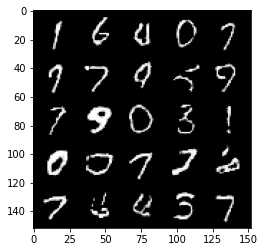

############################################################
###### Epoch 41 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


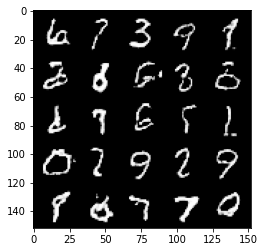

############################################################
###### Epoch 42 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


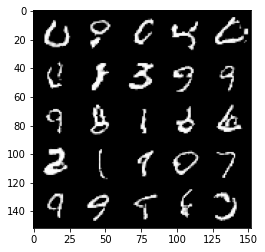

############################################################
###### Epoch 43 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.61	Loss Gen: -0.31


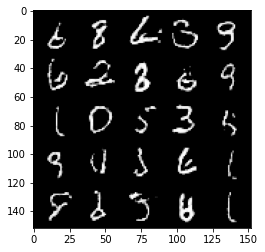

############################################################
###### Epoch 44 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


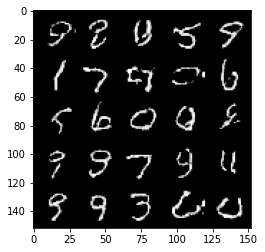

############################################################
###### Epoch 45 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


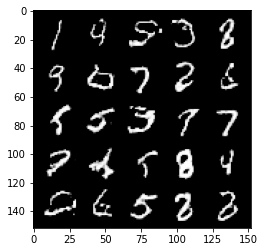

############################################################
###### Epoch 46 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


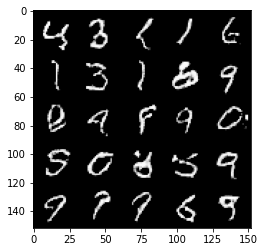

############################################################
###### Epoch 47 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


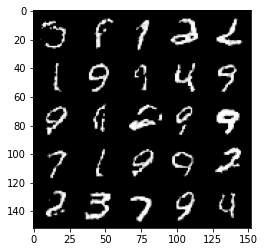

############################################################
###### Epoch 48 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.31


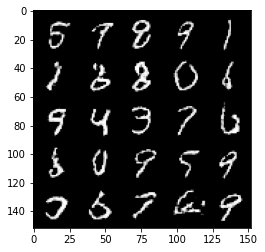

############################################################
###### Epoch 49 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


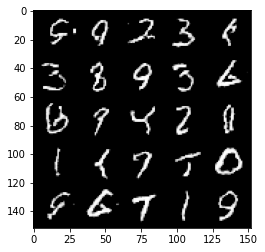

############################################################
###### Epoch 50 #############################################
############################################################


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss Dis: 0.60	Loss Gen: -0.30


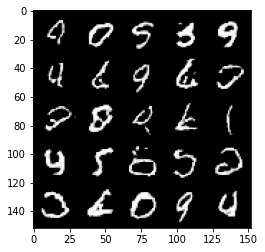

In [52]:
loss_gen_min = np.Inf

for epoch in range(1,epochs+1):
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # Set mode on "train mode"
    gen.train()
    dis.train()

    for real_image, _ in tqdm(dataloader):
        # GPU (model and data)
        real_image=real_image.to(device)

        # Discriminator Learning
        optim_dis.zero_grad()
        loss_dis = get_loss_dis(gen, dis, real_image, N_noise, C_noise, device)
        loss_dis.backward()
        optim_dis.step()

        # Generator Learning
        optim_gen.zero_grad()
        loss_gen = get_loss_gen(gen, dis, N_noise, C_noise, device)
        loss_gen.backward()
        optim_gen.step()

    # Save parameters of discriminator and generator
    save_model(gen, dis, epoch, root_models, mode='colab')
    print("Loss Dis: {:.2f}\tLoss Gen: {:.2f}".format(loss_dis.item(),loss_gen.item()))

    gen.eval()
    fake_images = gen(get_noise(25, C_noise, device=device))
    show_tensor_images(fake_images)